## PIMA 인디언 당뇨병 예측

In [7]:
import pandas as pd

pima_url = './data/diabetes.csv'

pima = pd.read_csv(pima_url)
pima.tail()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


In [3]:
pima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
pima = pima.astype('float')
pima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    float64
dtypes: float64(9)
memory usage: 54.1 KB


### 상관관계 확인

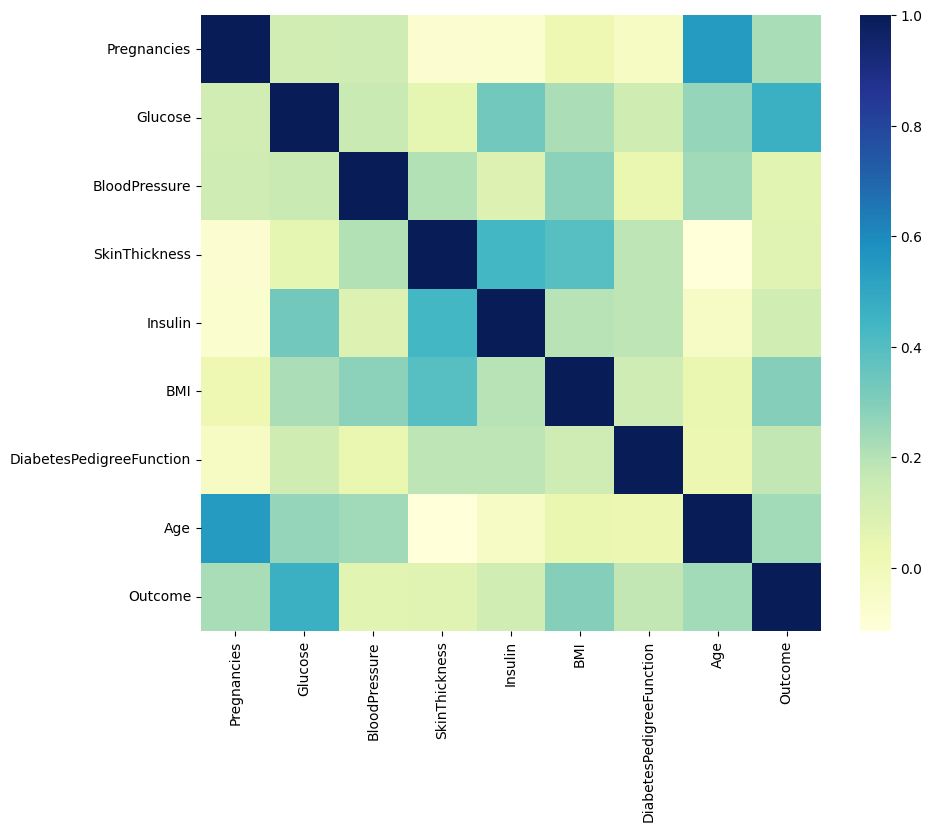

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,8))
sns.heatmap(pima.corr(), cmap = 'YlGnBu')
plt.show()

### 결측치 처리
- 혈압이 0인 부분은 결측치

In [6]:
(pima==0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

### 0인 부분은 평균값으로 대체

In [8]:
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
pima[zero_features] = pima[zero_features].replace(0, pima[zero_features].mean())
(pima==0).sum()

Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                     374
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

### 학습 준비

In [10]:
from sklearn.model_selection import train_test_split

x= pima.drop('Outcome', axis= 1)
y = pima['Outcome']

tr_dt, te_dt, tr_lb, te_lb = train_test_split(x, y, test_size=0.2, random_state=13,
                                              stratify=y)


### pipeline

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

estimators = [('scaler', StandardScaler()),
              ('clf', LogisticRegression(solver='liblinear', random_state=13))]

pipe_lr = Pipeline(estimators)
pipe_lr.fit(tr_dt, tr_lb)
pred = pipe_lr.predict(te_dt)


In [13]:
from sklearn.metrics import(accuracy_score, recall_score, precision_score,
                            roc_auc_score, f1_score)

print('ACcuracy : ', accuracy_score(te_lb, pred))
print('recall : ', recall_score(te_lb, pred))
print('precision : ', precision_score(te_lb, pred))
print('roc_auc : ', roc_auc_score(te_lb, pred))
print('f1 : ', f1_score(te_lb, pred))

ACcuracy :  0.7727272727272727
recall :  0.6111111111111112
precision :  0.7021276595744681
roc_auc :  0.7355555555555556
f1 :  0.6534653465346535


### 다변수 방정식의 계수 확인

In [14]:
coeff = list(pipe_lr['clf'].coef_[0])
labels = list(tr_dt.columns)

coeff

[0.3542658884412648,
 1.2014244425037581,
 -0.15840135536286715,
 0.03394657712929963,
 -0.16286471953988135,
 0.620404521989511,
 0.3666935579557874,
 0.1719596544703511]

In [15]:
labels

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [16]:
pipe_lr['clf'].coef_

array([[ 0.35426589,  1.20142444, -0.15840136,  0.03394658, -0.16286472,
         0.62040452,  0.36669356,  0.17195965]])

### feature 시각화
- 혈압은 예측에 부정적 영향을 준다
- 포도당 BMI 등은 당뇨에 영향을 미치는 정도가 높다

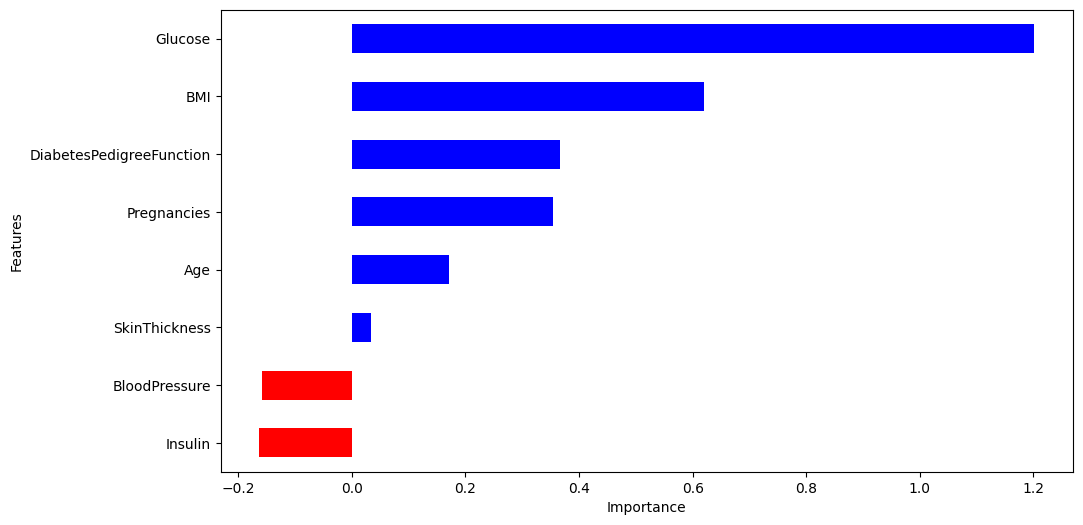

In [17]:
features = pd.DataFrame({'Features' : labels, 'importance' : coeff})
features.sort_values(by='importance', inplace=True)
features['positive'] = features['importance'] > 0
features.set_index('Features', inplace=True)
features['importance'].plot(kind='barh',
                            figsize=(11, 6),
                            color = features['positive'].map({True : 'blue',
                                                              False : 'red'}))
plt.xlabel('Importance')
plt.show()

In [18]:
features

,importance,positive
Features,,
Insulin,-0.162865,False
BloodPressure,-0.158401,False
SkinThickness,0.033947,True
Age,0.171960,True
Pregnancies,0.354266,True
DiabetesPedigreeFunction,0.366694,True
BMI,0.620405,True
Glucose,1.201424,True
